In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [6]:
import qldpc
from sympy.abc import x, y, z

dims = {x: 12, y: 6}
poly_a = x**3 + y + y**2
poly_b = y**3 + x + x**2

code = qldpc.codes.BBCode(dims, poly_a, poly_b)

Starting 10 workers...
Running...
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.00031622776601683794,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.0005274997063702619,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.0008799225435691075,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.0014677992676220691,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.002448436746822227,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.004084238652674522,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.006812920690579608,repetitions=3}
    bposd processes=1  

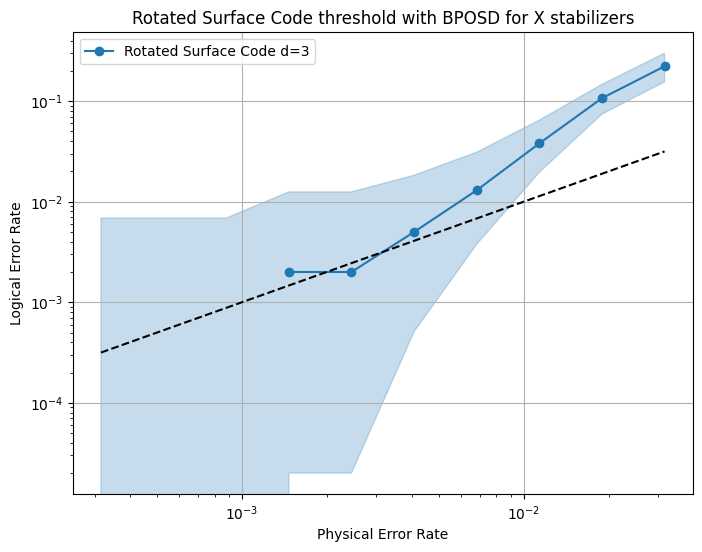

In [7]:
import numpy as np
import qldpc

distance = 3
BPOSD = qldpc.decoder.get_BP_OSD_decoder
shots = 1000
code_name = "Rotated Surface Code"
noise_range = np.logspace(-3.5, -1.5, 10)
sector = qldpc.objects.Pauli.X
code = qldpc.codes.SurfaceCode(distance, rotated=True)
samples = qldpc.simulator.run_simulation(
    code, distance, sector, noise_range, shots, BPOSD, code_name, overwrite=True
)
qldpc.simulator.plot_results(samples, code_name, sector, noise_range)

Starting 10 workers...
Running...
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.00031622776601683794,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.0005274997063702619,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.0008799225435691075,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.0014677992676220691,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.002448436746822227,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.004084238652674522,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=1000     errors_left=100     {d=3,noise=0.006812920690579608,repetitions=3}
    bposd processes=1  

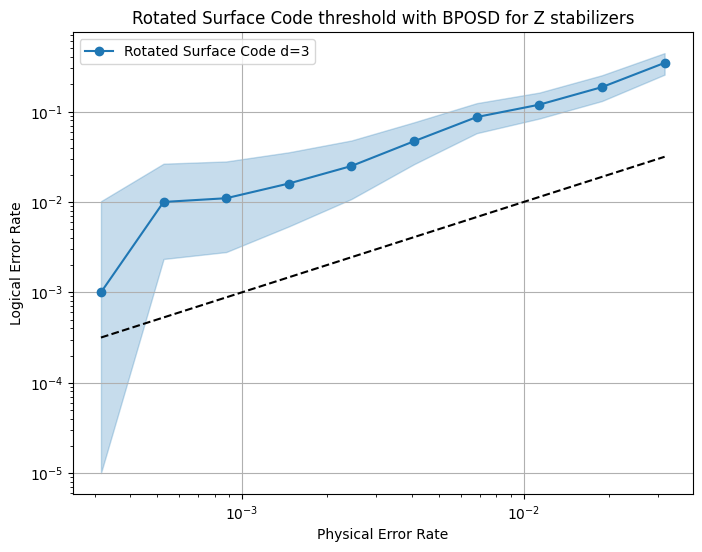

In [8]:
import numpy as np
import qldpc

distance = 3
BPOSD = qldpc.decoder.get_BP_OSD_decoder
shots = 1000
code_name = "Rotated Surface Code"
noise_range = np.logspace(-3.5, -1.5, 10)
sector = qldpc.objects.Pauli.Z
code = qldpc.codes.SurfaceCode(distance, rotated=True)
samples = qldpc.simulator.run_simulation(
    code, distance, sector, noise_range, shots, BPOSD, code_name, overwrite=True
)
qldpc.simulator.plot_results(samples, code_name, sector, noise_range)